We want to do use our usual thing: Comparing a model with a model on which we know what world-class performance looks like. So here we are once again, working on a curated CS2 data set.

In [1]:
from kan import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.preprocessing import MinMaxScaler

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data and select features
I really should do these in a function next to the dataset.

In [2]:
ROUND_IN_PROGRESS_ONLY = True

In [3]:
df = pd.read_csv('../autogluon_experiments/cs2_curated/cs2_curated.csv.zip', compression='gzip', low_memory=False)

# Some boiler-plate feature engineering:

# There are map names which start with a capital letter.
df.map_name = df.map_name.apply(str.lower)

# Make sure the round nr is an int:
df.round_nr = df.round_nr.astype(int)

# mark switch rounds: consider each round a switch round where the terrorist rating changes
# we do not care if this is a correct switch or not, if the teams change in the next round, we do not want to predict the next round
rwise = df.groupby('round_id').first().sort_values(by=['map_id', 'round_nr'])
for i in range(1, 4):
    rwise[f'switch_in_{i}'] = 13 - df.round_nr - i
df = df.merge(rwise[[f'switch_in_{i}' for i in range(1, 4)]], left_on='round_id', right_index=True)
total_rounds = df.groupby('map_id').round_nr.max()
total_rounds.name = 'total_rounds'
df = df.merge(total_rounds, left_on='map_id', right_index=True)

# Create the round winner lookups for the current and the next rounds.
# The result will be a table with the round_ids as indices and the round_winners as columns.
# E.g. round_winner_3 is the round winner three rounds from the current round, so if the current round is 10, then it would be round 13.
# This calculation only takes rounds which actually exist, so on columns after the match ends.
round_winner_table = df.groupby(['map_id', 'round_nr']).round_winner.last().dropna().astype(int).to_frame().rename(columns={'round_winner': 'round_winner_0'})

# For each horizon, join the round winner lookup with the shifted array. Note that we don't convert to int yet, as we can't; the rows will contain NaN:
for horizon in range(1, 4):
    round_winner_table = round_winner_table.join(
        round_winner_table.groupby(['map_id', 'round_nr'])['round_winner_0'].first().shift(-horizon).rename(f'round_winner_{horizon}')
    )

# Merge the round-winner-table back into the main dataframe and rename the columns while on the way:
df = df.merge(round_winner_table, left_on=['map_id', 'round_nr'], right_index=True, copy=False, validate='m:1')

In [4]:
# We do not want to do predictions into overtime or after round switch, which means we have to invalidate targets with a horizon in overtime:
# - All t_win_next(i) or target_i for round = 24, 12
# - All t_win_next(i) or target_i for i in (2, 3) for round = 23, 11
# - All t_win_next(i) or target_i for i in (3) for round = 22, 10
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_1'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 1, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 1, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds - 2, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_1'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 1, 'round_winner_2'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 1, 'round_winner_3'] = pd.NA
df.loc[df.round_nr == df.max_regular_rounds / 2 - 2, 'round_winner_3'] = pd.NA

# Disabled, since the curated set does not have switch_in_1 set:
#df.loc[df.switch_in_1, 'round_winner_1'] = pd.NA
#df.loc[df.switch_in_1, 'round_winner_2'] = pd.NA
#df.loc[df.switch_in_1, 'round_winner_3'] = pd.NA
#df.loc[df.switch_in_2, 'round_winner_2'] = pd.NA
#df.loc[df.switch_in_2, 'round_winner_3'] = pd.NA
#df.loc[df.switch_in_3, 'round_winner_3'] = pd.NA

In [5]:
# Create the target columns for this and the following rounds:
df['target_0'] = df['round_winner_0'].astype(int)
for k in range(1, 4):
    df[f'target_{k}'] = df[f'round_winner_{k}']

# Add fields indicating pistol rounds, the score difference and dominance, bin the pts and add an indicator whether it is a high-eco-sample(!) / in overtime:
df = df.assign(
    is_pistol_round = (df.round_nr == 1).astype(int) + (df.round_nr == df.max_regular_rounds // 2 + 1).astype(int),
    is_pistol_round_1 = (df.round_nr == df.max_regular_rounds // 2).astype(int),
    score_diff = df.t_round_score - df.ct_round_score,
    score_dominance = df.t_round_score / (df.t_round_score + df.ct_round_score),
    is_high_eco = (df.t_eq > 25_000) & (df.ct_eq > 25_000),
    is_overtime = df.round_nr > df.max_regular_rounds,
    t_pts_bin = pd.cut(df.t_pts, bins=np.linspace(0, 1.0, 21, endpoint=True)),
    t_pot = df.t_cash + df.t_eq,
    ct_pot = df.ct_cash + df.ct_eq,
)
df.score_dominance = df.score_dominance.fillna(0.5)

# Finally, we are only interested in real events, not that stupid round-start event which indicates the start of the buying phase.
df = df[df.event_type != 'round_start']

In [6]:
# Add the average death count to the mix:
for k in range(5):
    df[f't_p{k}_death_stat'] = df[f't_p{k}_deaths'] / df.round_nr
    df[f'ct_p{k}_death_stat'] = df[f'ct_p{k}_deaths'] / df.round_nr

In [7]:
# Please note that KANs do not allow for categorical features, so we will not use map-name here:
features = ['t_cash', 'ct_cash', 't_alive', 'ct_alive',  
    't_eq', 'ct_eq', #'t_losing_streak', 'ct_losing_streak', 
    'bomb_is_planted', 'bomb_is_defused', 't_pts', #'score_diff', 'score_dominance'
]
#features += [c for c in df if 'health' in c]
#features += [c for c in df if 'death_stat' in c]

In [8]:
# Make a train test split:
if ROUND_IN_PROGRESS_ONLY:
    df_train = df[:int(0.8 * len(df))].query('round_in_progress == True')[features + ['round_winner']]
    df_test = df[int(0.8 * len(df)):].query('round_in_progress == True')[features + ['round_winner']]

else:
    df_train = df[:int(0.8 * len(df))][features + ['round_winner']]
    df_test = df[int(0.8 * len(df)):][features + ['round_winner']]

# Train a KAN

In [9]:
# Create separate matrices for the KAN, as the KAN wants torch-style arrays. Also normalise it, while we are at it.
df_kan_train = df_train[features + ['round_winner']].sample(frac=0.1)
df_kan_test = df_test[features + ['round_winner']].sample(frac=0.1)

scaler = MinMaxScaler()

dataset = {
    'train_input': torch.from_numpy(scaler.fit_transform(df_kan_train[features])),
    'test_input': torch.from_numpy(scaler.fit_transform(df_kan_test[features])),
    'train_label': torch.from_numpy(df_kan_train.round_winner.to_numpy().astype(float)),
    'test_label': torch.from_numpy(df_kan_test.round_winner.to_numpy().astype(float)),
}

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.00e-01 | test_loss: 5.21e-01 | reg: 1.97e-01 | : 100%|█| 50/50 [01:13<00:00,  1.47s/


saving model version 0.1


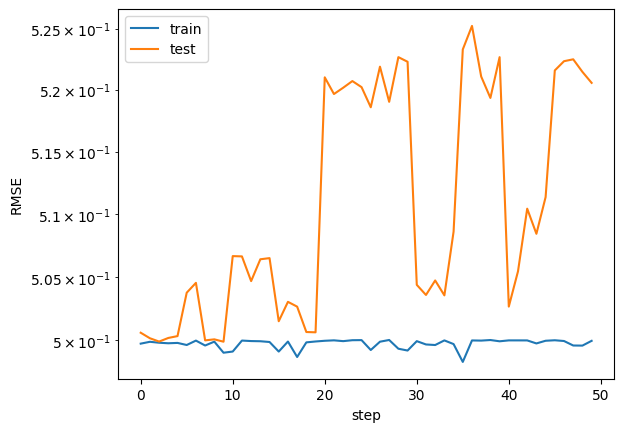

In [10]:
grids = [5]

train_losses = []
test_losses = []

for i, grid_size in enumerate(grids):
    if i == 0:
        kan_mdl = KAN(width=[len(features), 4, 1], grid=grid_size, k=3, seed=983457, device=device)
    else:
        kan_mdl = kan_mdl.refine(grid_size)
    res = kan_mdl.fit(dataset, opt="LBFGS", batch=2000, steps=50, lamb=0.001);
    train_losses += res['train_loss']
    test_losses += res['test_loss']

plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

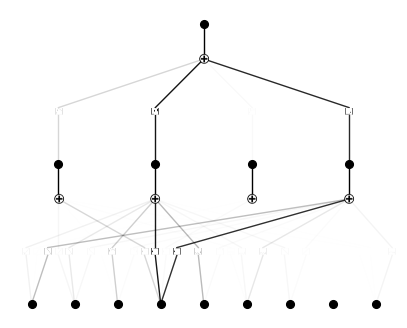

In [11]:
kan_mdl.plot()

The classifier fails soundly. Despite the most important features being expressive with correlations around 0.35'ish, the training loss stays at exactly 0.5.

A simple MLP trained in parallel does the job withtout problems and ofc Catboost does it as well. There seems to be something off with the optimisation when low-expressive features are in the mix. But that is just a hunch.